In [1]:
from functions import map_scatter, glasbey
from matplotlib.ticker import LogLocator, ScalarFormatter, NullFormatter
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, ttest_rel
from google.cloud import storage
from scipy import stats
from scipy.spatial import Delaunay
from matplotlib.collections import PatchCollection
from sklearn.preprocessing import QuantileTransformer
from matplotlib.patches import Polygon
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
from anndata import AnnData
import pandas as pd
import numpy as np
import seaborn as sns
import colorcet as cc
import scanpy as sc
# import nfinder
import copy
import os

In [2]:
# read in data
data_path = "gs://mayo-nguyen-transplant/nduarte-csv/data.csv"
df = pd.read_csv(data_path)

In [3]:
df.columns

Index(['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm',
       'Centroid Y µm', 'DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67',
       'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68',
       'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14',
       'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1',
       'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e', 'Slide',
       'UMAP1', 'UMAP2', 'PC1_1', 'PC2_1', 'PC3_1', 'PC4_1', 'PC5_1', 'PC6_1',
       'PC7_1', 'PC8_1', 'PC9_1', 'PC10_1', 'PC1_hcorr', 'PC2_hcorr',
       'PC3_hcorr', 'PC4_hcorr', 'PC5_hcorr', 'PC6_hcorr', 'PC7_hcorr',
       'PC8_hcorr', 'PC9_hcorr', 'PC10_hcorr', 'UMAP1_hcorr', 'UMAP2_hcorr',
       'Leiden', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Phenotype',
       'Timepoint'],
      dtype='object')

In [4]:
metadata = ['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm', 'Centroid Y µm', 'UMAP1_hcorr', 'UMAP2_hcorr', 'PC1_hcorr', 'PC2_hcorr', 'PC3_hcorr', 'PC4_hcorr', 'PC5_hcorr', 'PC6_hcorr', 'PC7_hcorr', 'PC8_hcorr', 'PC9_hcorr', 'PC10_hcorr', 'Leiden', 'Level 1', 'Level 2', 'Level 3',
       'Level 4', 'Phenotype', 'Timepoint']
markers = ['DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e']

In [5]:
print(len(df[df['Phenotype'] == 'Other']))
print(len(df[df['Phenotype'] != 'Other']))

0
4748619


### Hierarchical Clustering
Based on Figure S1C of [this](https://pubmed.ncbi.nlm.nih.gov/37059105/) paper.

Level 1 clustermap on a random subset

In [6]:
# get the proportion of each group in level 1
for p in df['Level 1'].unique():
    prop = len(df[df['Level 1'] == p]) / len(df.index)
    print(p, prop)
    

Other 0.5528457852693593
Immune 0.4467149291193924
Epithelial 0.0004392856112482387


In [7]:
# reduce size by getting mean within lymph nodes within level
df_mean = df[markers + ['Parent', 'Level 1']].groupby(['Parent']).mean(numeric_only=True).reset_index()

In [8]:
df_mean.head()

,Parent,DAPI,CD44,HLA-DR,CD4,IFNG,Ki67,CD107a,CD45,CD20,...,T-bet/TBX21,PD-L1,TOX,PD-1,CD38,ICOS,CD39,LAG3,TCF-1,CD3e
0,Slide 10 C1,4.694777,2.026346,1.138228,2.217296,0.184544,0.252294,2.978339,2.096525,1.330860,...,1.346122,0.604765,0.370924,0.200602,0.689861,0.651038,0.159491,0.980338,1.852201,1.898128
1,Slide 10 C1-1,4.576373,1.557356,1.042198,1.664700,0.209901,0.288565,2.758535,1.439023,0.830659,...,2.620824,0.468446,0.174629,0.109099,0.785534,0.420918,0.124540,0.809707,1.304875,1.128391
2,Slide 10 D1,4.679304,1.436170,1.239480,2.294137,0.218893,0.322738,2.775435,1.702805,0.943563,...,1.700890,0.536133,0.183997,0.410150,0.581272,0.723386,0.113951,1.111366,1.472208,1.646073
3,Slide 11 A1,4.664667,2.099985,1.568226,3.237306,0.230378,0.585567,2.968125,2.482107,1.203662,...,1.555993,0.934363,0.720421,0.426736,1.139535,1.265671,0.273745,0.443765,1.747130,2.747235
4,Slide 11 A1-1,4.599028,2.175794,1.715544,3.063913,0.252300,0.512571,3.259231,2.611142,1.203409,...,1.991898,0.712088,0.596090,0.268076,1.478410,0.933205,0.234995,0.812498,1.551163,2.287855


In [9]:
df_mean.columns

Index(['Parent', 'DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a',
       'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A',
       'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56',
       'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX',
       'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e'],
      dtype='object')

In [10]:
# reduce size by getting sample
lvl1_markers = ['CD45', 'Pan-Cytokeratin', 'CD3e', 'CD20', 'CD11c']
df_ss = df.sample(frac=0.1, random_state=57)

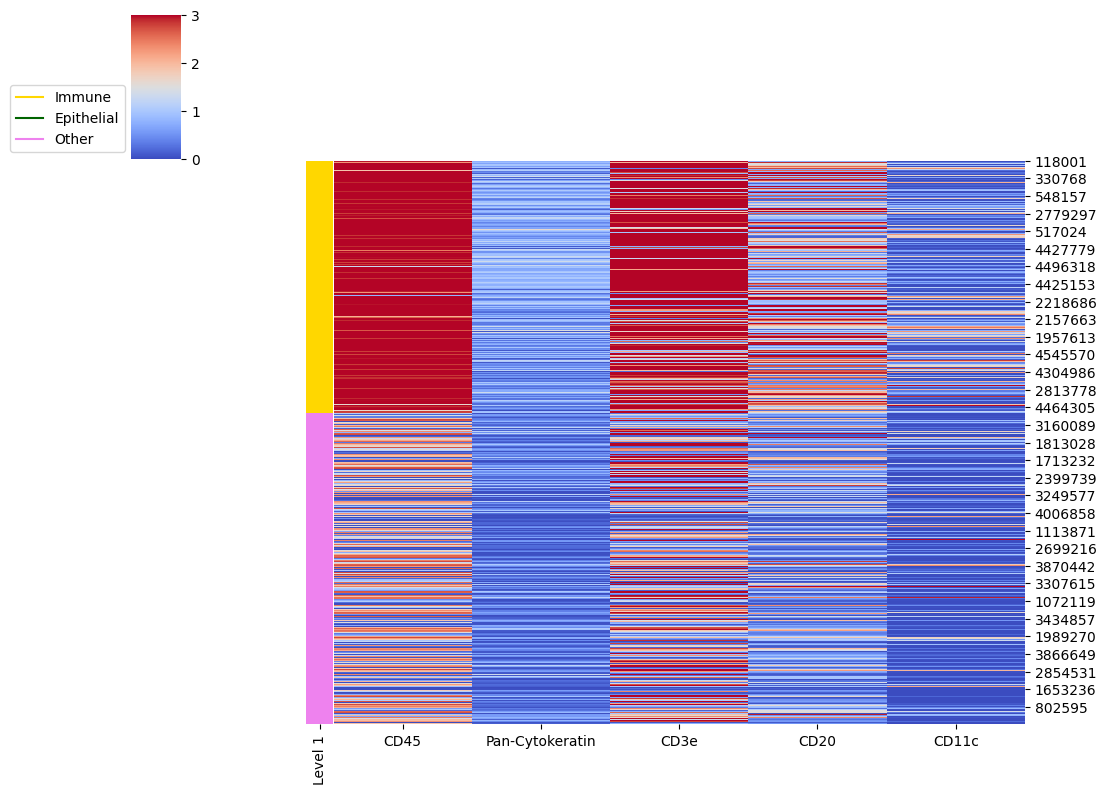

In [11]:
level1_colours = {
    'Immune': 'gold',
    'Epithelial': 'darkgreen',
    'Other': 'violet'
}

df_sorted = df_ss.sort_values(by=['Level 1', 'Level 2'])
row_colours = df_sorted['Level 1'].map(level1_colours) # map each row to a colour based on level
df_biomarkers = df_sorted[lvl1_markers] 

# plot
cg = sns.clustermap(df_biomarkers, row_colors=row_colours, cmap='coolwarm', figsize=(10, 8), vmin=0, vmax=3, row_cluster=False, col_cluster=False)
# cg.ax_heatmap.set_yticks([]) # suppress y-ticks

# legend - figure out separate legends 
for label in level1_colours:
    plt.plot([], [], color=level1_colours[label], label=label)
plt.legend(loc='lower right', bbox_to_anchor=(0, 0))

plt.show()

In [12]:
# reduce size by getting sample
filtered = df_ss[df_ss['Level 1'] == 'Immune'] # get the immune subset

In [13]:
rest_markers = ['CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a', 'CD20', 'CD40', 'CD8', 'CD68', 'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e']

levels = ['Level 2', 'Level 3', 'Level 4']

level2_colours = {
    'Lymphoid': 'gold',
    'Myeloid': 'darkorange',
    'Other': 'white'
}

level3_colours = {
    'Helper T': 'rebeccapurple',
    'Macrophage': 'paleturquoise',
    'Cyt T': 'mediumseagreen',
    'Dendritic': 'hotpink',
    'NK Cell': 'sienna',
    'Other': 'white'
}

level4_colours = {
    'T reg': 'gold',
    'Cyt T Precursor': 'blue',
    'Helper T Precursor': 'greenyellow',
    'Tc': 'red',
    'Exhausted Tc': 'deepskyblue',
    'Other': 'white'
}

df_sorted = df_ss.sort_values(by=levels)
row_lv2_colours = df_sorted['Level 2'].map(level2_colours) # map each row to a colour based on level
row_lv3_colours = df_sorted['Level 3'].map(level3_colours)
row_lv4_colours = df_sorted['Level 4'].map(level4_colours)
df_biomarkers = df_sorted[rest_markers] 
row_colours = pd.concat([row_lv4_colours, row_lv3_colours, row_lv2_colours], axis=1)
row_colours.head()

,Level 4,Level 3,Level 2
4365131,NaN,NaN,gold
1904563,NaN,NaN,gold
1877454,NaN,NaN,gold
2109117,NaN,NaN,gold
2071994,NaN,NaN,gold


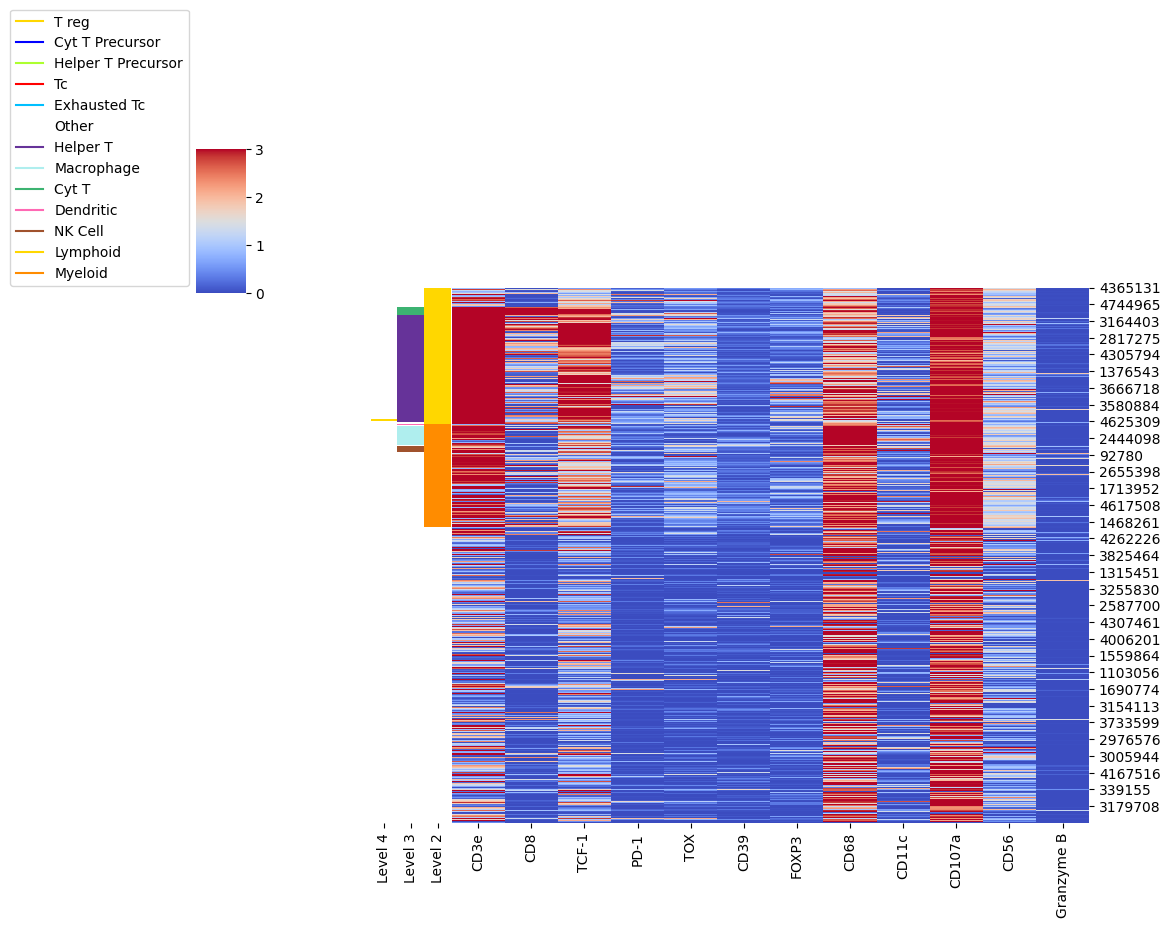

In [14]:
# plot
cm = sns.clustermap(df_biomarkers, row_colors=row_colours, cmap='coolwarm', figsize=(10, 8), vmin=0, vmax=3, row_cluster=False, col_cluster=False)
# cm.ax_heatmap.set_yticks([]) # suppress y-ticks

# legend - figure out separate legends 
colours = level4_colours | level3_colours | level2_colours
for label in colours:
    plt.plot([], [], color=colours[label], label=label)
plt.legend(loc='lower right', bbox_to_anchor=(0, 0))

plt.show()

### Figure 2 plots

log2 fold change in proportions of each phenotype from pre to post DLN

In [15]:
df.columns

Index(['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm',
       'Centroid Y µm', 'DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67',
       'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68',
       'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14',
       'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1',
       'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e', 'Slide',
       'UMAP1', 'UMAP2', 'PC1_1', 'PC2_1', 'PC3_1', 'PC4_1', 'PC5_1', 'PC6_1',
       'PC7_1', 'PC8_1', 'PC9_1', 'PC10_1', 'PC1_hcorr', 'PC2_hcorr',
       'PC3_hcorr', 'PC4_hcorr', 'PC5_hcorr', 'PC6_hcorr', 'PC7_hcorr',
       'PC8_hcorr', 'PC9_hcorr', 'PC10_hcorr', 'UMAP1_hcorr', 'UMAP2_hcorr',
       'Leiden', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Phenotype',
       'Timepoint'],
      dtype='object')

In [16]:
phen_prop = df.groupby(['Parent', 'Timepoint', 'Phenotype']).size().unstack(fill_value=0)
prop_df = phen_prop.div(phen_prop.sum(axis=1), axis=0)
prop_df.head()

,Phenotype,Act B,Act Cyt T,Act Dendritic,Act Helper T,Act Macrophage,Act NK,Ant Pres Dendritic,Ant Pres Macrophage,Ant Pres Monocyte,B Ant Rec,...,Myeloid,NK Cell,Other,Other Ant Pres Cell,PD-1+ Tc,Plasma B,Prolif B,Prolif Cyt T,T reg,Th1 Helper T
Parent,Timepoint,,,,,,,,,,,,,,,,,,,,,
Slide 10 C1,DLN post,0.000004,0.002457,0.000035,0.001849,0.000744,0.000819,0.000084,0.008603,0.000048,0.047480,...,0.071809,0.009611,0.560457,0.066139,0.000009,0.000013,0.005429,0.089557,0.008110,0.000418
Slide 10 C1-1,DLN post,0.000000,0.000357,0.000000,0.000232,0.000224,0.000247,0.000000,0.007529,0.000046,0.004695,...,0.027369,0.006765,0.777120,0.156594,0.000000,0.000000,0.000558,0.001782,0.000482,0.000190
Slide 10 D1,DLN post,0.000173,0.000089,0.000000,0.000804,0.001774,0.000073,0.000054,0.056957,0.000038,0.002636,...,0.012811,0.001274,0.720845,0.110162,0.000008,0.000000,0.011741,0.039744,0.002113,0.000127
Slide 11 A1,DLN pre,0.004072,0.007074,0.000080,0.023303,0.000587,0.000681,0.002358,0.003890,0.000031,0.003258,...,0.053076,0.013048,0.483240,0.053466,0.000185,0.000023,0.050570,0.085518,0.001475,0.001128
Slide 11 A1-1,DLN pre,0.000425,0.005563,0.000049,0.011045,0.002626,0.002176,0.000135,0.027746,0.000046,0.000686,...,0.066001,0.014251,0.470035,0.121366,0.000007,0.000073,0.020257,0.085115,0.006032,0.000450


In [17]:
mean_prop = prop_df.groupby('Timepoint').mean()
mean_prop.head()

Phenotype,Act B,Act Cyt T,Act Dendritic,Act Helper T,Act Macrophage,Act NK,Ant Pres Dendritic,Ant Pres Macrophage,Ant Pres Monocyte,B Ant Rec,...,Myeloid,NK Cell,Other,Other Ant Pres Cell,PD-1+ Tc,Plasma B,Prolif B,Prolif Cyt T,T reg,Th1 Helper T
Timepoint,,,,,,,,,,,,,,,,,,,,,
DLN post,0.000472,0.003690,0.000057,0.010642,0.000687,0.000592,0.000159,0.016516,0.000110,0.014811,...,0.047498,0.009158,0.611331,0.098379,0.000016,0.000066,0.014605,0.057407,0.003757,0.000436
DLN pre,0.000798,0.005931,0.000140,0.009531,0.001826,0.000921,0.000603,0.017140,0.000389,0.012700,...,0.041786,0.014130,0.513922,0.134035,0.000039,0.000024,0.025764,0.082482,0.003224,0.001565


In [18]:
log2_fold_change = np.log2(mean_prop.loc['DLN post'] / mean_prop.loc['DLN pre'])
log2_fold_change.head()

Phenotype
Act B            -0.757652
Act Cyt T        -0.684575
Act Dendritic    -1.283857
Act Helper T      0.159111
Act Macrophage   -1.409610
dtype: float64

In [19]:
prop_df.head()

,Phenotype,Act B,Act Cyt T,Act Dendritic,Act Helper T,Act Macrophage,Act NK,Ant Pres Dendritic,Ant Pres Macrophage,Ant Pres Monocyte,B Ant Rec,...,Myeloid,NK Cell,Other,Other Ant Pres Cell,PD-1+ Tc,Plasma B,Prolif B,Prolif Cyt T,T reg,Th1 Helper T
Parent,Timepoint,,,,,,,,,,,,,,,,,,,,,
Slide 10 C1,DLN post,0.000004,0.002457,0.000035,0.001849,0.000744,0.000819,0.000084,0.008603,0.000048,0.047480,...,0.071809,0.009611,0.560457,0.066139,0.000009,0.000013,0.005429,0.089557,0.008110,0.000418
Slide 10 C1-1,DLN post,0.000000,0.000357,0.000000,0.000232,0.000224,0.000247,0.000000,0.007529,0.000046,0.004695,...,0.027369,0.006765,0.777120,0.156594,0.000000,0.000000,0.000558,0.001782,0.000482,0.000190
Slide 10 D1,DLN post,0.000173,0.000089,0.000000,0.000804,0.001774,0.000073,0.000054,0.056957,0.000038,0.002636,...,0.012811,0.001274,0.720845,0.110162,0.000008,0.000000,0.011741,0.039744,0.002113,0.000127
Slide 11 A1,DLN pre,0.004072,0.007074,0.000080,0.023303,0.000587,0.000681,0.002358,0.003890,0.000031,0.003258,...,0.053076,0.013048,0.483240,0.053466,0.000185,0.000023,0.050570,0.085518,0.001475,0.001128
Slide 11 A1-1,DLN pre,0.000425,0.005563,0.000049,0.011045,0.002626,0.002176,0.000135,0.027746,0.000046,0.000686,...,0.066001,0.014251,0.470035,0.121366,0.000007,0.000073,0.020257,0.085115,0.006032,0.000450


In [20]:
prop_df.columns

Index(['Act B', 'Act Cyt T', 'Act Dendritic', 'Act Helper T', 'Act Macrophage',
       'Act NK', 'Ant Pres Dendritic', 'Ant Pres Macrophage',
       'Ant Pres Monocyte', 'B Ant Rec', 'B Cell', 'Cyt T', 'Cyt T Pre',
       'Dendritic', 'Early Ex Tc', 'Epithelial', 'Ex Tc', 'Helper T',
       'Helper T Pre', 'IFNG Sec NK', 'Imm Check+ Myeloid', 'Inhib Monocyte',
       'Macrophage', 'Mem Helper T', 'Monocyte', 'Myeloid', 'NK Cell', 'Other',
       'Other Ant Pres Cell', 'PD-1+ Tc', 'Plasma B', 'Prolif B',
       'Prolif Cyt T', 'T reg', 'Th1 Helper T'],
      dtype='object', name='Phenotype')

In [21]:
p_values = []
for phenotype in prop_df.columns:
    prop_t1 = prop_df.xs('DLN pre', level='Timepoint')[phenotype]
    prop_t2 =  prop_df.xs('DLN post', level='Timepoint')[phenotype]

    # run independent t-test
    _, p_value = ttest_rel(prop_t1, prop_t2) 
    print(p_value)
    p_values.append(p_value)

0.6996461510894193
0.5371804403282564
0.41324110786511375
0.8957597602468892
0.22379251818201798
0.46460512506208645
0.3020108981018305
0.9613723390636901
0.2714535329228684
0.8610841341840149
0.48379213223313516
0.749370795429466
0.9421890971384843
0.41079991248796505
0.6540399872466409
0.4212152222791402
0.9283334840877735
0.9718952756912511
0.9590584231274188
0.3796575902757597
0.8150749614035542
0.13340328756298803
0.40015911382406344
0.2014464526640089
0.9946007041366398
0.7967671048557218
0.17907054269684747
0.1765273079123894
0.2859319709784156
0.48224592108293624
0.44936188520289244
0.4110526708354001
0.6367294607808038
0.7892075894181102
0.25686998017607166


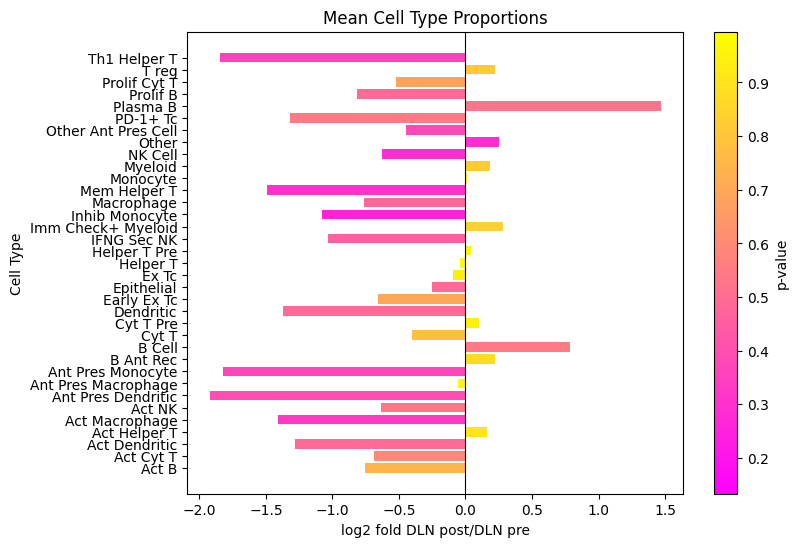

In [22]:
p_values = pd.Series(p_values, index=prop_df.columns)
cmap = mpl.cm.spring # colour map
colours = [cmap(p_val) for p_val in p_values]

# plot horizontal bar
fig, ax = plt.subplots(figsize=(8, 6))
phenotypes = log2_fold_change.index

bars = ax.barh(phenotypes, log2_fold_change, color=colours)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('log2 fold DLN post/DLN pre')
ax.set_ylabel('Cell Type')
ax.set_title('Mean Cell Type Proportions')

# p-value annotations
# for i, (log2_fc, p_val) in enumerate(zip(log2_fold_change, p_values)):
#     ax.text(log2_fc, i, f'p={p_val:.3e}', va='center', ha='right' if log2_fc < 0 else 'left')

# colour bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=p_values.min(), vmax=p_values.max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('p-value')

plt.show()

Plot change in ratio of phenotypes from pre to post DLN

In [23]:
print(df['Phenotype'].unique())

['Other' 'Ant Pres Macrophage' 'NK Cell' 'Other Ant Pres Cell'
 'Act Macrophage' 'Prolif Cyt T' 'Macrophage' 'Act NK' 'Myeloid'
 'Mem Helper T' 'Helper T Pre' 'Helper T' 'IFNG Sec NK' nan 'T reg'
 'B Ant Rec' 'Prolif B' 'Act Helper T' 'B Cell' 'Imm Check+ Myeloid'
 'Act Cyt T' 'Cyt T Pre' 'PD-1+ Tc' 'Cyt T' 'Dendritic' 'Ex Tc'
 'Epithelial' 'Act Dendritic' 'Th1 Helper T' 'Monocyte' 'Plasma B'
 'Inhib Monocyte' 'Ant Pres Dendritic' 'Ant Pres Monocyte' 'Act B'
 'Early Ex Tc']


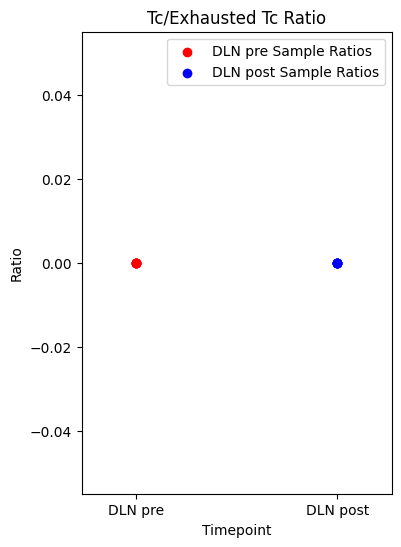

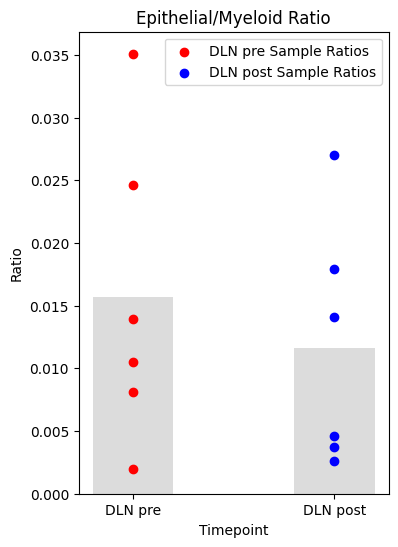

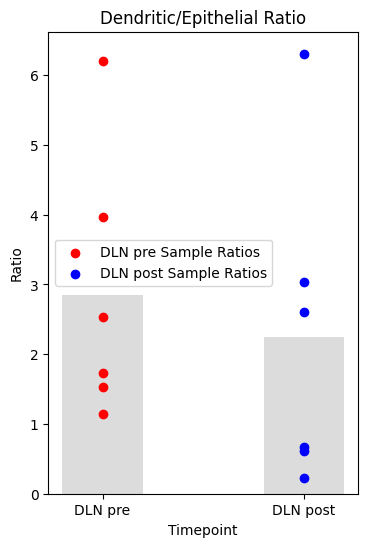

In [24]:
phen_ratios_toplot = [('Tc', 'Exhausted Tc'), ('Epithelial', 'Myeloid'), ('Dendritic', 'Epithelial')]
for pair in phen_ratios_toplot:

    timepoint_dict = {}
    for timepoint, group in df.groupby('Timepoint'):
        sample_ratios = []
        for sample, sample_group in group.groupby('Parent'):

            phen1 = sample_group['Phenotype'].value_counts().get(pair[0], 0)
            phen2 = sample_group['Phenotype'].value_counts().get(pair[1], 0)
            if phen2 > 0:
                ratio = phen1 / phen2
            else:
                ratio = 0  # denom 0 case
            sample_ratios.append(ratio)

        # bar height = avg ratio for the timepoint
        bar_height = np.mean(sample_ratios) if sample_ratios else 0
        timepoint_dict[timepoint] = (bar_height, sample_ratios)

    # plot
    fig, ax = plt.subplots(figsize=(4, 6))
    
    # define the order of timepoints
    timepoints = ['DLN pre', 'DLN post']
    
    bar_heights = [timepoint_dict.get(tp, (0, []))[0] for tp in timepoints]
    sample_ratios_list = [timepoint_dict.get(tp, ([], []))[1] for tp in timepoints]
    
    bars = ax.bar(timepoints, bar_heights, color='gainsboro', width=0.4)

    colors = {'DLN pre': 'red', 'DLN post': 'blue'}
    # add sample ratios as colored points
    for i, (timepoint, sample_ratios) in enumerate(zip(timepoints, sample_ratios_list)):
        ax.scatter([timepoint] * len(sample_ratios), sample_ratios, color=colors[timepoint], label=f'{timepoint} Sample Ratios', zorder=5)

    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Ratio')
    ax.set_title(f'{pair[0]}/{pair[1]} Ratio')
    ax.legend()
    plt.show()

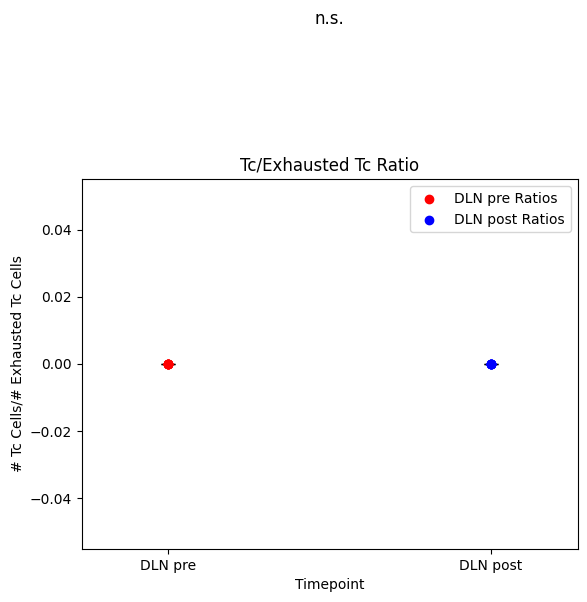

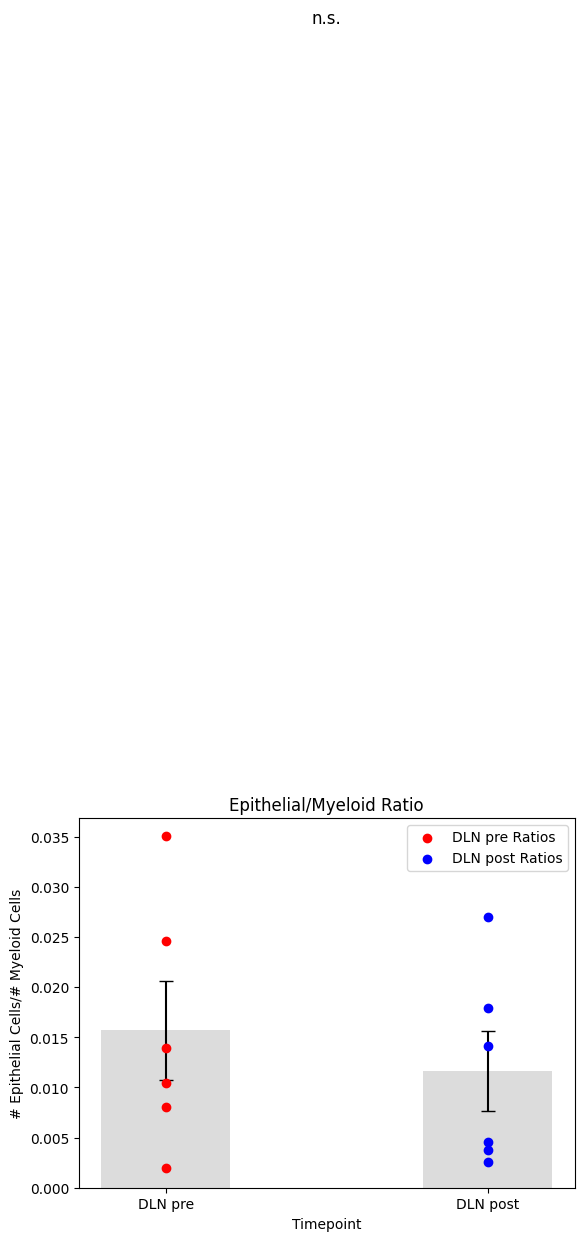

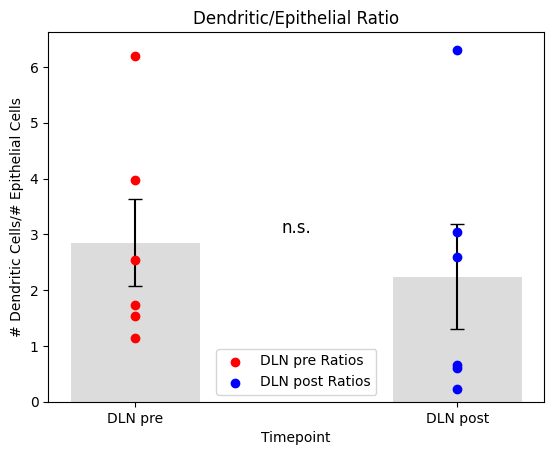

In [25]:
phen_ratios_toplot = [('Tc', 'Exhausted Tc'), ('Epithelial', 'Myeloid'), ('Dendritic', 'Epithelial')]
for pair in phen_ratios_toplot:
    timepoint_dict = {}
    for timepoint, group in df.groupby('Timepoint'):
        
        sample_ratios = []
        for sample, sample_group in group.groupby('Parent'):
            
            phen1 = sample_group['Phenotype'].value_counts().get(pair[0], 0)
            phen2 = sample_group['Phenotype'].value_counts().get(pair[1], 0)
        
            if phen2 > 0:
                ratio = phen1 / phen2
            else:
                ratio = 0  # denom 0 case
            sample_ratios.append(ratio)

        # get avg ratio and stderr for the timepoint
        if sample_ratios:
            bar_height = np.mean(sample_ratios)
            std_error = np.std(sample_ratios, ddof=1) / np.sqrt(len(sample_ratios))
        else:
            bar_height = 0
            std_error = 0

        timepoint_dict[timepoint] = (bar_height, std_error, sample_ratios)

    # plot
    fig, ax = plt.subplots()

    # define the order of timepoints
    timepoints = ['DLN pre', 'DLN post']
    bar_heights = [timepoint_dict[tp][0] for tp in timepoints]
    std_errors = [timepoint_dict[tp][1] for tp in timepoints]
    sample_ratios_list = [timepoint_dict[tp][2] for tp in timepoints]

    bars = ax.bar(timepoints, bar_heights, yerr=std_errors, color='gainsboro', width=0.4, capsize=5)
    colours = {'DLN pre': 'red', 'DLN post': 'blue'}  # updated colours dictionary

    # add sample ratios as coloured points
    for i, (timepoint, sample_ratios) in enumerate(zip(timepoints, sample_ratios_list)):
        if sample_ratios:  # unnecessary handling: check if there are ratios to plot
            ax.scatter([timepoint] * len(sample_ratios), sample_ratios, color=colours[timepoint], label=f'{timepoint} Ratios', zorder=5)

    # determine whether not sig diff or sig, and display p-value if so
    for i in range(len(timepoints)):
        for j in range(i + 1, len(timepoints)):
            tp1 = timepoints[i]
            tp2 = timepoints[j]

            bar1, err1 = bar_heights[i], std_errors[i]
            bar2, err2 = bar_heights[j], std_errors[j]

            if (bar1 - err1 <= bar2 + err2) and (bar1 + err1 >= bar2 - err2):
                ax.text((i + j) / 2, max(bar_heights) + 0.1, 'n.s.', ha='center', va='bottom', fontsize=12)
            else:
                # two-tailed independent t-test
                _, p_value = ttest_ind(timepoint_dict[tp1][2], timepoint_dict[tp2][2], equal_var=False)
                if p_value < 0.1:
                    ax.text((i + j) / 2, max(bar_heights) + 0.1, f'p = {p_value:.2f}', ha='center', va='bottom', fontsize=12)

    ax.set_xlabel('Timepoint')
    ax.set_ylabel(f'# {pair[0]} Cells/# {pair[1]} Cells')
    ax.set_title(f'{pair[0]}/{pair[1]} Ratio')
    ax.legend()
    plt.show()


bar plots of simple marker proportions pre and post

/tmp/ipykernel_7346/250881572.py:55: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_upper_limit + y_margin + annotation_offset)


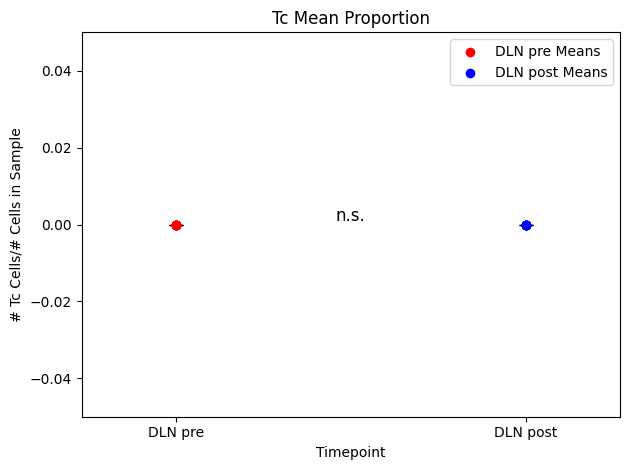

/tmp/ipykernel_7346/250881572.py:55: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_upper_limit + y_margin + annotation_offset)


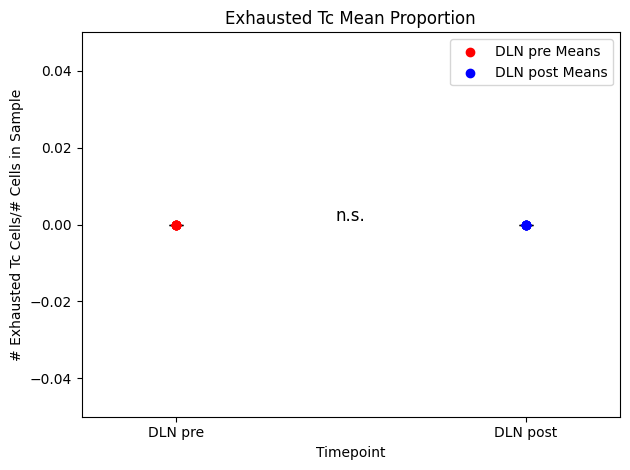

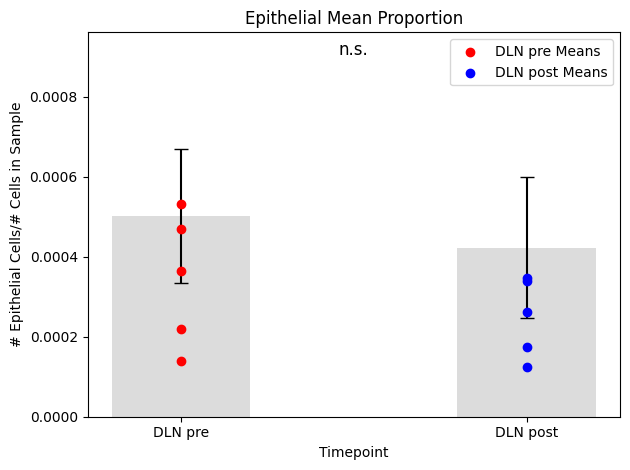

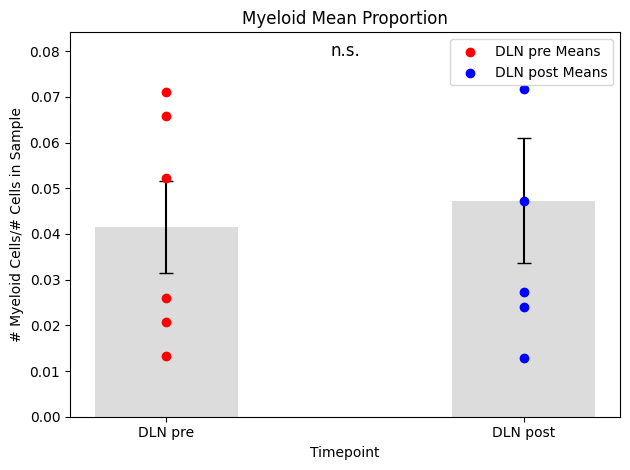

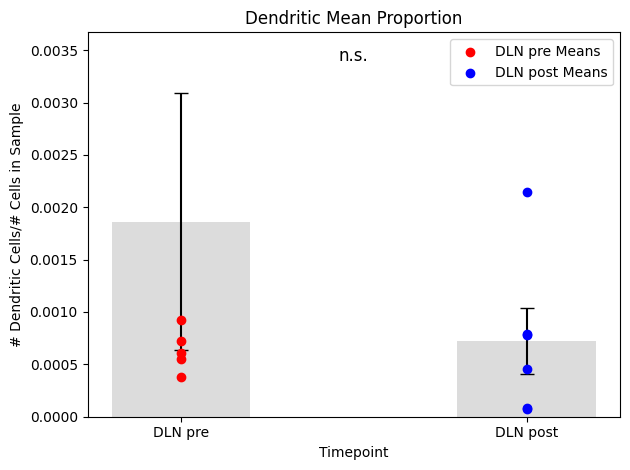

In [26]:
def calculate_proportions(df, phenotype):
    timepoint_dict = {}
    for timepoint, group in df.groupby('Timepoint'):
        sample_means = []
        for _, sample_group in group.groupby('Parent'):
            phen_count = (sample_group['Phenotype'] == phenotype).sum()
            denom = len(sample_group)
            mean = phen_count / denom if denom > 0 else 0
            sample_means.append(mean)

        bar_height = np.mean(sample_means) if sample_means else 0
        std_error = np.std(sample_means, ddof=1) / np.sqrt(len(sample_means)) if sample_means else 0
        timepoint_dict[timepoint] = (bar_height, std_error, sample_means)
    
    return timepoint_dict

def plot_proportions(timepoint_dict, phenotype):
    timepoints = ['DLN pre', 'DLN post']
    colours = {'DLN pre': 'red', 'DLN post': 'blue'}

    fig, ax = plt.subplots()
    
    bar_heights = [timepoint_dict[tp][0] for tp in timepoints]
    std_errors = [timepoint_dict[tp][1] for tp in timepoints]
    sample_means_list = [timepoint_dict[tp][2] for tp in timepoints]

    bars = ax.bar(timepoints, bar_heights, yerr=std_errors, color='gainsboro', width=0.4, capsize=5)

    for i, (timepoint, sample_means) in enumerate(zip(timepoints, sample_means_list)):
        ax.scatter([timepoint] * len(sample_means), sample_means, color=colours[timepoint], label=f'{timepoint} Means', zorder=5)

    # 
    upper_limits = [bar_heights[i] + std_errors[i] for i in range(len(timepoints))]
    max_upper_limit = max(upper_limits) if upper_limits else 0
    y_margin = max(sample_means) * 0.20
    # y_margin = 0.10 * max_upper_limit  # 10% of the highest upper limit
    annotation_offset = 0.05 * max_upper_limit  

    for i in range(len(timepoints)):
        for j in range(i + 1, len(timepoints)):
            tp1, tp2 = timepoints[i], timepoints[j]
            bar1, err1 = bar_heights[i], std_errors[i]
            bar2, err2 = bar_heights[j], std_errors[j]

            if (bar1 - err1 <= bar2 + err2) and (bar1 + err1 >= bar2 - err2):
                y_text = max_upper_limit + y_margin - annotation_offset
                ax.text((i + j) / 2, y_text, 'n.s.', ha='center', va='bottom', fontsize=12)
            else:
                _, p_value = ttest_ind(timepoint_dict[tp1][2], timepoint_dict[tp2][2], equal_var=False)
                if p_value < 0.1:
                    y_text = max_upper_limit + y_margin - annotation_offset
                    ax.text((i + j) / 2, y_text, f'p = {p_value:.2f}', ha='center', va='bottom', fontsize=12)

    
    ax.set_ylim(0, max_upper_limit + y_margin + annotation_offset)

    ax.set_xlabel('Timepoint')
    ax.set_ylabel(f'# {phenotype} Cells/# Cells in Sample')
    ax.set_title(f'{phenotype} Mean Proportion')
    ax.legend()
    plt.tight_layout()  
    plt.show()


phenotypes_toplot = ['Tc', 'Exhausted Tc', 'Epithelial', 'Myeloid', 'Dendritic']
for phenotype in phenotypes_toplot:
    timepoint_dict = calculate_proportions(df, phenotype)
    plot_proportions(timepoint_dict, phenotype)


log2 fold change of biomarkers of interest from pre to post DLN in select phenotypes of interest

In [27]:
print(df['Phenotype'].unique())

['Other' 'Ant Pres Macrophage' 'NK Cell' 'Other Ant Pres Cell'
 'Act Macrophage' 'Prolif Cyt T' 'Macrophage' 'Act NK' 'Myeloid'
 'Mem Helper T' 'Helper T Pre' 'Helper T' 'IFNG Sec NK' nan 'T reg'
 'B Ant Rec' 'Prolif B' 'Act Helper T' 'B Cell' 'Imm Check+ Myeloid'
 'Act Cyt T' 'Cyt T Pre' 'PD-1+ Tc' 'Cyt T' 'Dendritic' 'Ex Tc'
 'Epithelial' 'Act Dendritic' 'Th1 Helper T' 'Monocyte' 'Plasma B'
 'Inhib Monocyte' 'Ant Pres Dendritic' 'Ant Pres Monocyte' 'Act B'
 'Early Ex Tc']


In [28]:
phenotypes_of_interest = ['Exhausted Tc', 'Cyt T', 'Exhausted Tc', 'Dendritic', 'Epithelial', 'Myeloid']
markers_oi = ['CD3e', 'CD8', 'TCF-1', 'PD-1', 'TOX', 'CD39', 'FOXP3', 'CD68', 'CD11c', 'CD107a', 'CD56', 'Granzyme B']

for phenotype in phenotypes_of_interest:
    # get phenotype of interest
    filtered_df = df[df['Phenotype'] == phenotype]

    mean_prop = filtered_df.groupby(['Parent', 'Timepoint', 'Phenotype'])[markers_oi].mean()
    mean_intensities = mean_prop.groupby('Timepoint')[markers_oi].mean()
    log2_fold_change = np.log2(mean_intensities.loc['DLN post'] / mean_intensities.loc['DLN pre'])

    # independent t-test to get p-values
    p_values = []
    for marker in markers_oi:
        values_t1 = mean_prop.xs('DLN pre', level='Timepoint')[marker] 
        values_t2 = mean_prop.xs('DLN post', level='Timepoint')[marker] 
        
        if len(values_t1) == len(values_t2):
            _, p_value = ttest_rel(values_t1, values_t2)
        else:
            _, p_value = ttest_ind(values_t1, values_t2, equal_var=False)
        p_values.append(p_value)

    p_values = pd.Series(p_values, index=markers_oi)
    cmap = mpl.cm.spring # colour map
    colours = [cmap(p_val) for p_val in p_values]

    # horizontal bar plot
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.barh(log2_fold_change.index, log2_fold_change, color=colours)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_xlabel('log2 fold DLN post/DLN pre')
    ax.set_ylabel('Biomarker Mean Exp')
    ax.set_title(f'{phenotype} Biomarker Expression')

    # colour bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=p_values.min(), vmax=p_values.max()))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('p-value')

    plt.show()


KeyError: 'DLN post'

In [ ]:
preparents = ['Slide 11 B1', 'Slide 11 A1', 'Slide 11 A1-1', 'Slide 9 A1', 'Slide 9 B2', 'Slide 9 A1-1']
pre = df_ss[df_ss['Parent'].isin(preparents)]
post = df_ss[~df_ss['Parent'].isin(preparents)]

for tp in [('DLN Pre', pre), ('DLN Post', post)]:
    title, frame = tp
    corr = frame[markers_oi].corr()  # compute correlation matrix

    # mask for the upper triangle
    # mask = np.triu(np.ones_like(corr, dtype=bool))

    # plot 
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, 
                # mask=mask, 
                cmap=mpl.cm.spring, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_title(f'{title} correlation matrix of subset')


Heatmap of cell types and pre and post DLN

In [ ]:
phenotype_counts = df.groupby(['Parent', 'Timepoint', 'Phenotype']).size().unstack(fill_value=0)
phenotype_counts = phenotype_counts.div(phenotype_counts.sum(axis=1), axis=0)
phenotype_counts.head()

In [ ]:
mean_counts = phenotype_counts.groupby('Timepoint').mean()
mean_counts.head()

In [ ]:
# plot
plt.figure(figsize=(10, 8))
sns.heatmap(mean_counts.T, annot=True, cmap='YlGnBu', cbar=True, linewidths=0.5)
plt.title('Mean Proportion of Each Phenotype by Timepoint inc. Other')
plt.xlabel('Phenotype')
plt.ylabel('Timepoint')
plt.show()

In [ ]:
wo_other = mean_counts.drop(columns=['Other'])
print(wo_other.columns)
wo_other = wo_other.T

In [ ]:
# plot
plt.figure(figsize=(10, 8))
sns.heatmap(wo_other, annot=True, cmap='YlGnBu', cbar=True, linewidths=0.5)
plt.title('Mean Proportion of Each Phenotype by Timepoint Without Other')
plt.xlabel('Phenotype')
plt.ylabel('Timepoint')
plt.show()

In [ ]:
df.columns

In [ ]:
# plot the slides
for slide, group in df.groupby('Parent'):
    # plot the xy coordinates 
    f, ax = plt.subplots(figsize=(10, 10))

    sns.scatterplot(
        x="Centroid X µm", 
        y="Centroid Y µm",
        hue="Phenotype",
        legend="full",
        palette="rainbow",
        data=group,
        ax=ax,
        s=0.5
    ).set(title=f'{slide} xy plot')

    sns.despine()
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, markerscale=20, borderaxespad=0.)
    plt.show()

In [ ]:
df.columns

In [ ]:
for slide, group in df.groupby('Parent'):
    points = group[['Centroid X µm', 'Centroid Y µm']].to_numpy()
    tri = Delaunay(points)

    f, ax = plt.subplots(figsize=(10, 10))

    sns.scatterplot(
        x="Centroid X µm", 
        y="Centroid Y µm",
        hue="Phenotype",
        legend="full",
        palette="rainbow",
        data=group,
        ax=ax,
        s=0.5
    ).set(title=f'{slide} xy plot')

    # plot Delaunay triangulation edges
    for simplex in tri.simplices:
        simplex_points = points[simplex]
        ax.plot(
            np.append(simplex_points[:, 0], simplex_points[0, 0]),
            np.append(simplex_points[:, 1], simplex_points[0, 1]),
            'k-', lw=0.5
        )

    sns.despine()
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, markerscale=20, borderaxespad=0.)
    plt.show()

In [3]:
def plot_filtered_triangulation(ax, points, filtered_edges, title):
    """ Plot the Delaunay triangulation with filtered edges (2D array) """
    for edge in filtered_edges:
        x_values = [points[edge[0]][0], points[edge[1]][0]]
        y_values = [points[edge[0]][1], points[edge[1]][1]]
        ax.plot(x_values, y_values, 'r-', lw=1)
    ax.scatter(points[:, 0], points[:, 1], c='blue', s=20)
    ax.set_title(title)

def plot_zoomed_triangulation(ax, points, filtered_edges, title, zoom_factor=0.01):
    """
    Plot a zoomed-in section of the Delaunay triangulation with filtered edges (2D array).

    Parameters:
    ax: matplotlib axis object to plot on
    points: numpy array of shape (n, 2), representing the coordinates of points
    filtered_edges: list of edges to plot, where each edge is a tuple of two point indices
    title: title of the plot
    zoom_factor: float, fraction of the graph to zoom in on, centered at the middle
    """
    # zoom in on center of the graph
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2

    width = (max_x - min_x) * zoom_factor
    height = (max_y - min_y) * zoom_factor

    x_min_zoom = center_x - width / 2
    x_max_zoom = center_x + width / 2
    y_min_zoom = center_y - height / 2
    y_max_zoom = center_y + height / 2

    # filter points within the zoomed bounding box
    zoomed_points = points[
        (points[:, 0] >= x_min_zoom) & (points[:, 0] <= x_max_zoom) &
        (points[:, 1] >= y_min_zoom) & (points[:, 1] <= y_max_zoom)
    ]
    
    # map original points to their indices
    point_index_map = {tuple(point): idx for idx, point in enumerate(points)}
    zoomed_point_indices = {point_index_map[tuple(point)] for point in zoomed_points}

    # filter edges within the zoomed area
    zoomed_edges = [
        edge for edge in filtered_edges
        if edge[0] in zoomed_point_indices and edge[1] in zoomed_point_indices
    ]

    # plot
    for edge in zoomed_edges:
        x_values = [points[edge[0]][0], points[edge[1]][0]]
        y_values = [points[edge[0]][1], points[edge[1]][1]]
        ax.plot(x_values, y_values, 'r-', lw=1)
    ax.scatter(zoomed_points[:, 0], zoomed_points[:, 1], c='blue', s=20)

    # set plot limits to the zoomed area
    ax.set_xlim(x_min_zoom, x_max_zoom)
    ax.set_ylim(y_min_zoom, y_max_zoom)
    ax.set_title(title)


def filter_edges(tri, distance_cutoff, phenotype_mask):
    """ Filter edges based on a single distance cutoff and phenotype mask. """
    edges = set()
    for simplex in tri.simplices:
        for i in range(3):
            edges.add(tuple(sorted([simplex[i], simplex[(i + 1) % 3]])))
    
    points = tri.points
    filtered_edges = []

    # create a mask to determine valid vertices
    valid_vertices = set()
    for vertex_index in range(len(points)):
        if phenotype_mask[vertex_index]:
            valid_vertices.add(vertex_index)

    for edge in edges:
        if edge[0] in valid_vertices and edge[1] in valid_vertices:
            p1, p2 = points[edge[0]], points[edge[1]]
            distance = np.linalg.norm(p1 - p2)
            if distance <= distance_cutoff:
                filtered_edges.append(edge)
    
    return filtered_edges

def analyze_slide(df, distance_cutoffs, phenotypes_oi):
    """ Analyze each slide, perform triangulation, filter edges for each cutoff, and plot. """
    grouped = df.groupby('Parent')
    
    for name, group in grouped:
        coords = group[['Centroid X µm', 'Centroid Y µm']].values
        phenotypes = group['Phenotype'].values

        phenotype_mask = np.array([phenotype in phenotypes_oi for phenotype in phenotypes])
        
        # Delaunay triangulation
        tri = Delaunay(coords)
        
        # plot for each distance cutoff
        num_cutoffs = len(distance_cutoffs)
        fig, axs = plt.subplots(1, num_cutoffs, figsize=(15, 5))
        if num_cutoffs == 1:
            axs = [axs]
        
        for i, cutoff in enumerate(distance_cutoffs):
            filtered_edges = filter_edges(tri, cutoff, phenotype_mask) # get filtered graph
            plot_zoomed_triangulation(axs[i], coords, filtered_edges, f'Cutoff: {cutoff} µm')
        
        plt.suptitle(f'Slide ID: {name}')
        plt.show()


In [4]:
distance_cutoffs = [10, 25, 50]
analyze_slide(df, distance_cutoffs)